In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv('../Data/processed/zips_with_clusters.csv')
#df = pd.read_csv('../Data/model_inputs/model_input.csv')

In [14]:
#!pip install geopandas
import geopandas as gpd

g_df = gpd.read_file('../Data/raw/ny_new_york_zip_codes_geo.min.json')


def avg_val(zi):

    test = g_df[g_df['ZCTA5CE10'] == str(int(zi))]
    li = gpd.sjoin(g_df, test)['ZCTA5CE10_left'].astype(int).to_list()

    if int(zi) in li:
        li.remove(int(zi))
    if len(li) == 0:
        li.append(0)
    return df[df.zip.isin(li)].revised_market_value.mean()

In [15]:
df['neighbor_average'] = df.zip.map(avg_val)
df = df.dropna()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['revised_market_value', 'Unnamed: 0', 'zip'], axis = 1), df[['revised_market_value']], test_size=0.2, random_state=42)

In [34]:
#!conda install python=3.11.0 --yes
!python --version

Python 3.10.15


In [35]:
#!pip install pycaret
#!pip install mlflow
from pycaret.regression import *

In [36]:
clf1 = setup(df.drop(['Unnamed: 0', 'zip'], axis = 1), target = 'revised_market_value', session_id=123, log_experiment=False, experiment_name='Cluster1')

,Description,Value
0,Session id,123
1,Target,revised_market_value
2,Target type,Regression
3,Original data shape,"(193, 28)"
4,Transformed data shape,"(193, 28)"
5,Transformed train set shape,"(135, 28)"
6,Transformed test set shape,"(58, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [37]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2382518.3965,46925929644131.2656,4478864.0993,-0.3467,1.4230,1.0520,0.0050
par,Passive Aggressive Regressor,3020349.9111,58183952872864.5859,5289376.0304,-1.0253,1.5775,1.4832,0.0040
dummy,Dummy Regressor,2923180.6000,43350338463334.3984,4656023.9750,-1.9149,1.5927,2.4365,0.0030
br,Bayesian Ridge,2923001.1625,43357415433830.3984,4656315.3625,-1.9149,1.5927,2.4366,0.0050
omp,Orthogonal Matching Pursuit,3041045.8125,45986077894246.3984,4976340.9000,-2.4668,1.6407,2.6663,0.0030
en,Elastic Net,3314048.0875,46155035390771.2031,5118739.1375,-4.4193,1.7262,2.9380,0.0040
ada,AdaBoost Regressor,2910748.5409,48768913631252.8906,5149722.7177,-5.2229,1.5511,2.0666,0.0080
knn,K Neighbors Regressor,3192897.2875,50483000246272.0000,5591025.8750,-6.0590,1.5417,2.4771,0.0060
rf,Random Forest Regressor,2992284.5202,48999152866529.6016,5483305.9509,-6.3519,1.5114,2.0620,0.0190
lightgbm,Light Gradient Boosting Machine,3280590.1953,47412067397216.5547,5351883.2125,-6.8043,1.7740,3.0518,0.0630


In [38]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


reg = HuberRegressor()

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('huber', reg)  
    ])


pipeline.fit(X_train, y_train)

comp = y_test.copy()
comp['pred'] = pipeline.predict(X_test)
comp['err'] = (abs(comp['revised_market_value']-comp['pred'])/comp['pred'])*100


m_comp = df[['Cluster', 'zip']].merge(comp, left_index = True, right_index = True)
m_comp.sort_values(by = 'err')

,Cluster,zip,revised_market_value,pred,err
134,1,11213.0,1.068843e+06,1.112107e+06,3.890283
154,1,11234.0,1.317275e+06,1.411530e+06,6.677497
15,2,10018.0,2.702798e+06,3.230768e+06,16.341937
164,1,11355.0,1.597785e+06,1.913453e+06,16.497319
18,2,10021.0,1.923310e+06,2.373688e+06,18.973753
133,0,11212.0,4.215769e+05,5.334795e+05,20.975982
174,3,11366.0,9.162027e+05,1.297529e+06,29.388669
83,0,10452.0,1.540250e+06,1.156438e+06,33.189099
90,1,10459.0,5.832229e+05,9.387598e+05,37.873048
92,1,10461.0,9.745397e+05,1.626643e+06,40.088907


In [39]:
# Save our model
from pickle import dump
with open('../model/supervised_model.pkl', 'wb') as f:
    dump(pipeline, f, protocol=5)

In [40]:
err_train = mean_absolute_percentage_error(y_train, pipeline.predict(X_train))
err_test = mean_absolute_percentage_error(y_test, pipeline.predict(X_test))
print(f"Train Error: {err_train} | Test error: {err_test:.3f}")

Train Error: 3.5333730721545052e+19 | Test error: 0.911


In [42]:
i_df = pd.DataFrame(reg.coef_)
i_df.index = df.drop(['revised_market_value', 'Unnamed: 0', 'zip'], axis = 1).columns
i_df['p/n'] = '+'
i_df.loc[i_df[0] < 0, ['p/n']] = '-'
i_df[0] = abs(i_df[0])
i_df = i_df.sort_values(by = 0, ascending = True)
i_df

,0,p/n
DAY CARE AND PRE-KINDERGARTEN,2647.058626,-
EMERGENCY SERVICES,3751.579821,+
SCHOOLS (K-12),7358.587552,-
"CITY AGENCY PARKING, MAINTENANCE, AND STORAGE",10752.529662,-
YOUTH SERVICES,14720.670562,-
MATERIAL SUPPLIES AND MARKETS,23284.042027,-
HUMAN SERVICES,24202.636657,-
TELECOMMUNICATIONS,24702.851523,+
OTHER PROPERTY,27801.677244,-
Cluster,34601.308103,-


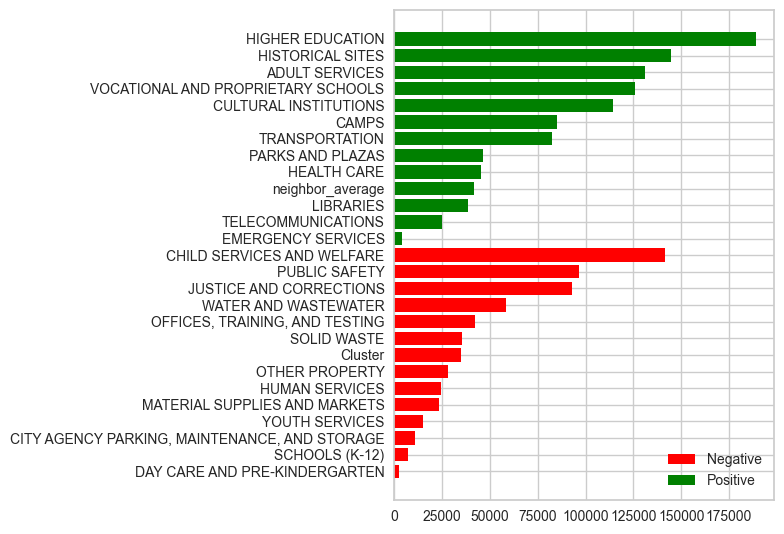

In [43]:
import matplotlib.pyplot as plt

p_df = i_df[i_df['p/n'] == '+']
n_df = i_df[i_df['p/n'] == '-']


plt.barh(n_df.index, n_df[0], label = 'Negative', color = 'Red')
plt.barh(p_df.index, p_df[0], label = 'Positive', color = 'Green')

plt.legend()
plt.tight_layout()
plt.savefig('Model_coef.png')